In [32]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score


In [33]:
train_data=pd.read_csv('Features/train_set_FINAL.csv',index_col=0)
test_data=pd.read_csv('Features/test_set_FINAL.csv',index_col=0)

In [34]:
train_data.columns

Index(['Unnamed: 0.1', 'id', 'keyword', 'location', 'text', 'target',
       'caracteres_usados', 'menciones_realizadas', 'permite_location',
       'use_keyword', 'cita_url', 'use_hashtag', 'cant_palabras',
       'cant_abreviaciones', 'location_usa', 'has_emoji',
       'has_repeated_letter', 'numero_de_palabras', 'palabras_unicas',
       'numero_palabras_desconocidas', 'menciona_pais'],
      dtype='object')

In [35]:
features= ['caracteres_usados', 'menciones_realizadas', 'permite_location',
       'use_keyword', 'cita_url', 'use_hashtag', 'cant_palabras',
       'cant_abreviaciones', 'location_usa', 'has_emoji',
       'has_repeated_letter', 'numero_de_palabras', 'palabras_unicas',
       'numero_palabras_desconocidas', 'menciona_pais']

In [36]:
X = train_data[features]
Y = train_data['target']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [37]:
kfold = KFold(n_splits=10)

In [38]:
xgbRegressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=1, learning_rate=0.075,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=95, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.8, seed=15,
       subsample=0.8)

In [39]:
mejor_score = 0
for train, test in kfold.split(X_train, Y_train):
    train_datas = train_data.iloc[train]
    test_datas = train_data.iloc[test]
    
    X_train_data = train_datas[features]
    Y_train_data = train_datas['target']
    
    X_test_data = test_datas[features]
    Y_test_data = test_datas['target']
    
    xgbRegressor.fit(X_train_data,Y_train_data)
    print(roc_auc_score(Y_test_data,xgbRegressor.predict(X_test_data)))
    if (roc_auc_score(Y_test_data, xgbRegressor.predict(X_test_data))>mejor_score):
        mejor_score = roc_auc_score(Y_test_data,xgbRegressor.predict(X_test_data))
        X_train_optimo = X_train_data
        Y_train_optimo = Y_train_data
        X_test_optimo = X_test_data
        Y_test_optimo = Y_test_data

0.7315144452412663
0.6665513939135987
0.6661574892029839
0.7096302512460584
0.7045153220762976
0.7039740470397406
0.7162351469668543
0.6963859277677934
0.649582471462499
0.7328687281432922


In [40]:
params = {'objective':['binary:logistic'],'colsample_bytree': [0.5,.6,.7,.8,.9,1.0], 'learning_rate': [.07,.075,.08,.085,.09,.095,1.0],
                'max_depth' : [1,2,3,4,5,6,7,8,9,10], 'n_estimators' : [80,85,90,95,100],'seed':[123]}

In [41]:
cv = GridSearchCV(estimator=xgb.XGBRegressor(),param_grid=params,scoring='roc_auc',cv=3)

In [42]:
dmatrix = xgb.DMatrix(data=X_train_optimo[features],label=Y_train_optimo,feature_names=features)

In [44]:
cv.best_score

AttributeError: 'GridSearchCV' object has no attribute 'best_score'

In [45]:
xgbRegressor.fit(X_train_optimo,Y_train_optimo)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.075, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=95, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=0.8, seed=15, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
roc_auc_score(Y_test_optimo,xgbRegressor.predict(X_test_optimo))

0.7328687281432922

In [47]:
xg_reg = xgb.train(params={'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bytree':1, 'gamma':1,'learning_rate':0.075, 'max_delta_step':0,
'max_depth':4, 'min_child_weight':1, 'n_estimators':95,
'n_jobs':1, 'objective':'binary:logistic', 'random_state':0,
'reg_alpha':0,'reg_lambda':1, 'scale_pos_weight':0.8,
'silent':True, 'subsample':0.8}, dtrain=dmatrix, num_boost_round=10)

[17:56:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




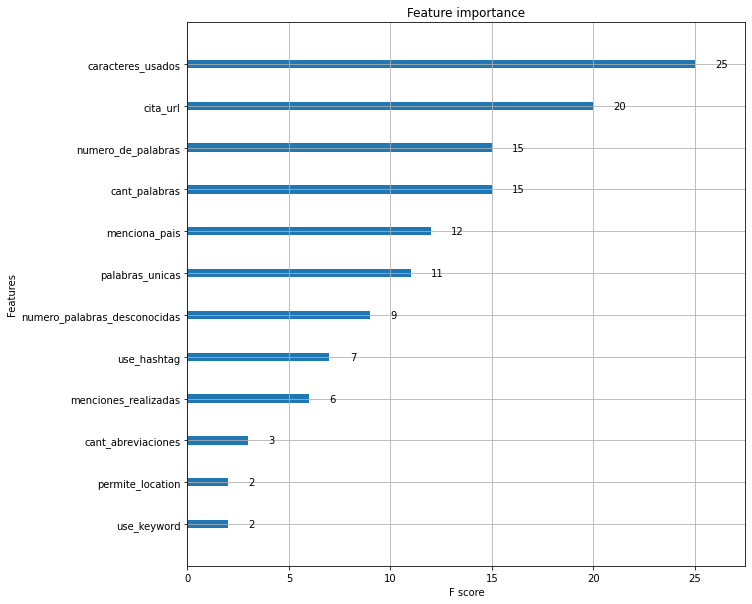

In [48]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Test Kaggle


In [49]:
test_data['prediction'] = xgbRegressor.predict(test_data[features])

In [50]:
submit_kaggle = pd.DataFrame({'id':test_data['id'],'target':test_data['prediction']})

In [51]:
submit_kaggle['target'] = submit_kaggle['target'].transform(lambda x: 0 if x < 0.5 else 1)
#submit_kaggle['target'] = submit_kaggle['target'].transform(lambda x: 1.0 if x > 1.0 else x)

In [52]:
submit_kaggle.to_csv('submit_kaggle_xgboost.csv',index=False)

In [53]:
submit_kaggle

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
